## Inference and Validation

In [1]:
import torch
from torchvision import datasets, transforms

In [2]:
# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
# Download and load the training data
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

### Create a Custom model

In [15]:
import torch.nn as nn
import torch.nn.functional as F

In [37]:
class FashionMnistClassifier(nn.Module):
    
    def __init__(self):
        
        super().__init__()
        
        self.input = nn.Linear(784, 256)
        self.fc1 = nn.Linear(256, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)
    
    def forward(self, x):
        x = x.view(x.shape[0],-1)
        x = F.relu(self.input(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.log_softmax(self.fc3(x),dim=1)
        
        return x
      
        

In [38]:
class_model = FashionMnistClassifier()
print(class_model)

FashionMnistClassifier(
  (input): Linear(in_features=784, out_features=256, bias=True)
  (fc1): Linear(in_features=256, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)


In [39]:
loss_criteria = nn.NLLLoss()
print(loss_criteria)

NLLLoss()


In [40]:
import torch.optim as optim

In [41]:
adam_optimizer = optim.Adam(class_model.parameters(),lr=0.01)
print(adam_optimizer)

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.01
    weight_decay: 0
)


In [42]:
epochs = 5

for e in range(epochs):
    cumulative_loss = 0
    
    for images, lables in trainloader:
        
        adam_optimizer.zero_grad()
        
        logPs = class_model(images)
        loss = loss_criteria(logPs, lables)
        loss.backward()
        adam_optimizer.step()
        
        cumulative_loss += loss.item()
        
    else:
        print(f'Epoch = {e}, cumulative_loss = {cumulative_loss/len(trainloader)}')

Epoch = 0, cumulative_loss = 0.581052034696155
Epoch = 1, cumulative_loss = 0.4650608664477812
Epoch = 2, cumulative_loss = 0.42486830239992407
Epoch = 3, cumulative_loss = 0.41450860913692
Epoch = 4, cumulative_loss = 0.4062561432340506


Let us see how our model behaves on the test data. 

In [43]:
test_model = FashionMnistClassifier()

In [49]:
test_imgs, test_lbls = next(iter(testloader))
test_imgs.shape, test_lbls.shape

(torch.Size([64, 1, 28, 28]), torch.Size([64]))

Let us get the probability

In [45]:
# in our model we are using nn.LogSoftmax() so we get the log(probability)
log_probability = test_model(test_imgs)

In [46]:
# from linear algebra to get the probablity we take the exp(log_probability) which cancels out the e
probability = torch.exp(log_probability)

In [47]:
probability.shape

torch.Size([64, 10])

In [53]:
#probability.topk(1)
??probability.topk()

Docstring:
topk(k, dim=None, largest=True, sorted=True) -> (Tensor, LongTensor)

See :func:`torch.topk`
Type:      builtin_function_or_method


In [55]:
top_prob, top_class = probability.topk(1, dim=1)
top_prob.shape, top_class.shape

(torch.Size([64, 1]), torch.Size([64, 1]))

In [64]:
top_class[:10,:]

tensor([[5],
        [0],
        [0],
        [5],
        [5],
        [5],
        [0],
        [5],
        [5],
        [5]])

In [66]:
eq = top_class == test_lbls
eq.shape

torch.Size([64, 64])

In [78]:
eq = top_class == test_lbls.view(*top_class.shape)
eq.shape

# below code also gives the same dimention tensor not sure why '*' is used.
#eq = top_class == test_lbls.view(top_class.shape)
#eq.shape


torch.Size([64, 1])

In [83]:
eq.type(), top_class.type(), top_prob.type()

('torch.ByteTensor', 'torch.LongTensor', 'torch.FloatTensor')

In [85]:
predict_mean = torch.mean(eq)

RuntimeError: Can only calculate the mean of floating types. Got Byte instead.

In [87]:
predict_mean = torch.mean(eq.type(torch.FloatTensor))
predict_mean

tensor(0.1094)

In [89]:
accuacy = predict_mean * 100
print(f'Accuracy = {accuacy} %')

Accuracy = 10.9375 %


In [91]:
my_model = FashionMnistClassifier()
loss_criterion = nn.NLLLoss()
adm_optim = optim.Adam(my_model.parameters(), lr=0.01)



In [105]:
epochs = 30

training_loss = []
testing_loss = []
for e in range(epochs):
    cum_loss = 0
    
    for images, lables in trainloader:
        
        adm_optim.zero_grad()
        
        log_prob = my_model(images)
        loss = loss_criterion(log_prob, lables)
        loss.backward()
        adm_optim.step()
        
        cum_loss += loss.item()
        
    else:
        test_loss = 0
        accuracy = 0
        
        with torch.no_grad():
            
            for tst_imgs, tst_lbls in testloader:
                
                tst_log_ps = my_model(tst_imgs)
                test_loss += loss_criterion(tst_log_ps, tst_lbls)
                
                ps = torch.exp(tst_log_ps)
                top_prob, top_class = ps.topk(1,dim=1)
                eq = top_class == tst_lbls.view(*top_class.shape)
                predict_mean = torch.mean(eq.type(torch.FloatTensor))
                accuracy += predict_mean
                
        training_loss.append(cum_loss/len(trainloader))
        testing_loss.append(test_loss/len(testloader))

        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(cum_loss/len(trainloader)),
              "Test Loss: {:.3f}.. ".format(test_loss/len(testloader)),
              "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))
            
            
        #print(f'Epoch = {e} , Loss = {cum_loss/len(trainloader)} Accuracy = {acc}%')

Epoch: 1/30..  Training Loss: 0.539..  Test Loss: 0.507..  Test Accuracy: 0.849
Epoch: 2/30..  Training Loss: 0.321..  Test Loss: 0.546..  Test Accuracy: 0.849
Epoch: 3/30..  Training Loss: 0.310..  Test Loss: 0.434..  Test Accuracy: 0.861
Epoch: 4/30..  Training Loss: 0.290..  Test Loss: 0.452..  Test Accuracy: 0.869
Epoch: 5/30..  Training Loss: 0.300..  Test Loss: 0.506..  Test Accuracy: 0.863
Epoch: 6/30..  Training Loss: 0.304..  Test Loss: 0.464..  Test Accuracy: 0.864
Epoch: 7/30..  Training Loss: 0.293..  Test Loss: 0.506..  Test Accuracy: 0.860
Epoch: 8/30..  Training Loss: 0.301..  Test Loss: 0.505..  Test Accuracy: 0.856
Epoch: 9/30..  Training Loss: 0.305..  Test Loss: 0.503..  Test Accuracy: 0.862
Epoch: 10/30..  Training Loss: 0.286..  Test Loss: 0.448..  Test Accuracy: 0.864
Epoch: 11/30..  Training Loss: 0.311..  Test Loss: 0.503..  Test Accuracy: 0.865
Epoch: 12/30..  Training Loss: 0.323..  Test Loss: 0.478..  Test Accuracy: 0.868
Epoch: 13/30..  Training Loss: 0.304.

In [106]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

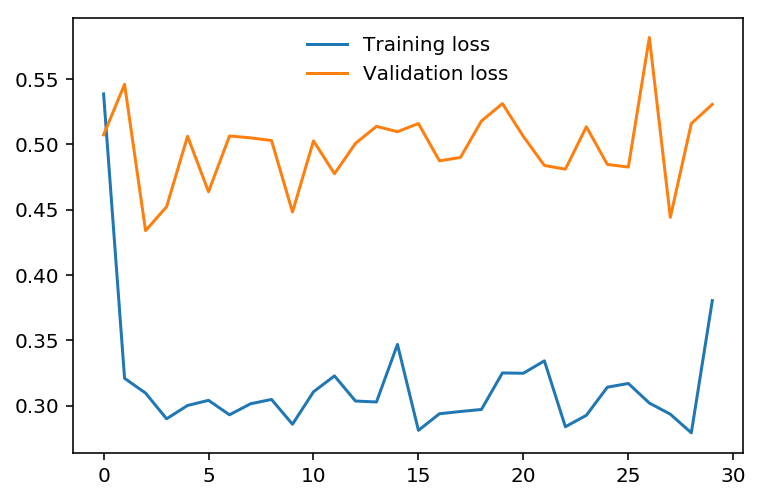

In [107]:
plt.plot(training_loss, label='Training loss')
plt.plot(testing_loss, label='Validation loss')
plt.legend(frameon=False)

The Zen of Python, by Tim Peters

Beautiful is better than ugly.
Explicit is better than implicit.
Simple is better than complex.
Complex is better than complicated.
Flat is better than nested.
Sparse is better than dense.
Readability counts.
Special cases aren't special enough to break the rules.
Although practicality beats purity.
Errors should never pass silently.
Unless explicitly silenced.
In the face of ambiguity, refuse the temptation to guess.
There should be one-- and preferably only one --obvious way to do it.
Although that way may not be obvious at first unless you're Dutch.
Now is better than never.
Although never is often better than *right* now.
If the implementation is hard to explain, it's a bad idea.
If the implementation is easy to explain, it may be a good idea.
Namespaces are one honking great idea -- let's do more of those!
